In [2]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
# To make plot backgrounds white
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"
import matplotlib.pyplot as plt
import pandas as pd
import os
sys.path.append('/home/arnau/documents/ETHZ/Semester_Project_Master_Thesis/plotMithraPy')
import plotMiFuncs as pmf
sys.path.append('/home/arnau/documents/ETHZ/Semester_Project_Master_Thesis/pyOPALTools')
from opal.parser.H5Parser import H5Parser
from decimal import Decimal
from scipy.signal import find_peaks

########################
for_report = False
prefixes = [
    # 'tests/case1/',
    'tests/case1/',
    # 'tests/case2/',
    # 'tests/case3/',
    # 'tests/case4/',
]

# prefixes.reverse()
generic_fn = 'fullBeamline'
fs = 14
########################

if not for_report:
    from datetime import date
    today = date.today()
    footnote = 'A.Albà, ' + str(today) + '\ndir: /' + (os.path.split(os.getcwd()))[1]
#     footnote = 'A.Albà, ' + str(today)
    print(footnote)
    generic_title = 'Linacs with intial modulation'
else:
    generic_title = " "
    footnote = " "
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
A.Albà, 2020-04-29
dir: /convergence_static


# Functions

In [6]:
def cutoff(x,y,cut = []):
    # Sort according to x
    idx   = np.argsort(x)
    x = np.array( x )[idx]
    y = np.array( y )[idx]
    if len(cut) != 2:
        return [ x, y ]
    # Trim data
    i = 0
    while( x[i] < cut[0] ):
        i += 1
    j = len(x) - 1   
    while( x[j] > cut[1] ):
        j -= 1    
    return [ x[ i : j ], y[ i : j ] ]


def get_ps_xy( fn, step, qx, qy, boolprint = False ):    
    ''' Get data to plot from file fn and given step. qx and qy are arrays of strings with data to plot
    eg ['z'], ['x', 'E'] '''
    h5p = H5Parser()
    h5p.parse( fn, boolprint )
    x = []
    for qi in qx:
        x.append( h5p.getStepDataset( dsetName = qi, step = step) )
    y  = []
    for qi in qy:
        if qi == 'E':
            # Get E
            E = []
            px = h5p.getStepDataset( dsetName = 'px', step = step)
            py = h5p.getStepDataset( dsetName = 'py', step = step)
            pz = h5p.getStepDataset( dsetName = 'pz', step = step)
            for i, pxi in enumerate(px):
                p2 = px[i]**2 + py[i]**2 + pz[i]**2  
                E.append( np.sqrt( 1 + p2 )*.511 )
            y.append( E )
        else:
            y.append( h5p.getStepDataset( dsetName = qi, step = step) )
    
    spos = h5p.getStepAttribute('SPOS', step = step)
    nSteps = h5p.getNSteps()
    if ( boolprint ):
        print(h5p.getStepDatasets(step = step))
        print('spos = ',spos)
    if len(x) == 1:
        x = x[0]
    if len(y) == 1:
        y = y[0]

    
    return [ x, y, spos[0], nSteps ]


def get_screen_xy( fn_prefix, screen_name, qx, qy, show = False ):    
    ''' Get data to plot from file fn and given screen. qx and qy are arrays of strings with data to plot
    eg ['z'], ['x', 'E'] '''
    fn = fn_prefix + screen_name
    h5p = H5Parser()
    step = 0
    h5p.parse( fn, False )
    if show:
        print(h5p)
        
    x = h5p.getStepDataset( dsetName = qx, step = step)
    if qy == 'E':
        # Get E
        E = []
        px = h5p.getStepDataset( dsetName = 'px', step = step)
        py = h5p.getStepDataset( dsetName = 'py', step = step)
        pz = h5p.getStepDataset( dsetName = 'pz', step = step)
        for i, pxi in enumerate(px):
            p2 = px[i]**2 + py[i]**2 + pz[i]**2  
            E.append( np.sqrt( 1 + p2 )*.511 )
        y = E
    else:
        y = h5p.getStepDataset( dsetName = qy, step = step)
            
    spos = h5p.getStepAttribute('SPOS', step = step)
    print('spos = ',spos)

    
    return [ x, y, spos[0] ]


def FT( x, y, cut = [], nbins = 100, boolplot = False, prominence = 0.0 ):
    [x, y] = cutoff( x, y, cut )
    # Set y data to average 0
    y -= np.average(y)
    # Get data organised in bins
    x_bins = np.linspace( np.min(x), np.max(x), nbins )
    digitized = np.digitize( x, x_bins ) - 1 
    y = np.array(y)
    y_means = [ y[digitized == i].mean() for i in range(nbins) ]
    # Plot
    if boolplot:
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(15, 5)
        ax[0].scatter( x_bins, y_means, marker = '.', color = 'k' )
        ax[0].grid()
        ax[0].tick_params( axis = 'both', labelsize = fs)
        if len(cut) != 0:
            ax[0].set_xlim( left = cut[0], right = cut[1]  )
    # Fourier transform        
    dist = np.max(x) - np.min(x)
    amp = np.fft.fft(y_means)[:nbins//2] / nbins
    freq = np.arange( nbins//2 ) / dist
    # Find peak frequencies
    peaks, _ = find_peaks( np.abs(amp), prominence = prominence )
    amp_peaks = np.abs(amp)[peaks]
    peaks = peaks / dist
    if boolplot:
        for peak in peaks:
            ax[1].axvline( peak, color = 'r' )
        ax[1].plot( freq, np.abs(amp) )
        ax[1].grid()
        ax[1].tick_params( axis = 'both', labelsize = fs)
        ax[1].set_xlabel('freq [$m^-1$]')
        print('peaks at ', peaks)
    
    return [ freq, amp, peaks, amp_peaks ]

def adjust_axes_limits( axs, axis = 'x' ):
    '''
    Adjusts all axis ranges to the one with the biggest range
    axs : (list or array af matplotlib axes)
    axis : (string) Indicates whether to adjust x or y axis
    '''
    crange = []
    for ax in axs:
        if axis == 'x':
            crange.append( np.ptp(ax.get_xlim()) )
        elif axis == 'y':
            crange.append( np.ptp(ax.get_ylim()) )

    def change_limits( ax, r, axis = 'x' ):
        if axis == 'x':
            ax.set_xlim( ax.get_xlim()[0] - r/2., ax.get_xlim()[1] + r/2.)
        elif axis == 'y':
            ax.set_ylim( ax.get_ylim()[0] - r/2., ax.get_ylim()[1] + r/2.)

    r = np.max(crange)
    for i, ax in enumerate(axs):
        change_limits( ax, r - crange[i], axis = axis  )

In [7]:
def getStats(fn, show = False):
    print(fn)
    text = open( fn, 'r' )
    names = []
    units = []
    for line in text:
        if 'name' in line:
            ind1 = line.find('=')
            ind2 = line.find(',')
            name = line[ind1+1:ind2]
        if 'units' in line:
            ind1 = line.find('=')
            ind2 = line.find(',')
            unit = line[ind1+1:ind2]
            if unit == '1':
                unit = ' '
            names.append( name )
            units.append( unit )
    if show:
        for i, n in enumerate(names):        
            print( i, n, ' [', units[i], ']' )
    stat = pd.read_csv( filepath_or_buffer = fn,
                        skiprows = 279, sep = '\s+', names = names)
    return[stat, names, units]

# Plot stats

In [8]:
fn = prefixes[0] + generic_fn + '.stat'
[stat, names, units] = getStats(fn, show = False)

tests/case1/fullBeamline.stat


In [7]:
################################
xax = 1
ylax = 4
yrax = 39  # -1 to plot only one quantity
colorL = 'r'
colorR = 'b'
getValuesAt = [12]
################################
x = np.array( stat[names[xax]] )
labxax = str( names[xax] + ' [' + units[xax] + ']')

y = np.array( stat[names[ylax]] )
labyax = str( names[ylax] + ' [' + units[ylax] + ']')

fig, ax1 = plt.subplots()
if 'emit' in labyax:
    ax1.semilogy(x, y*1e6,color = colorL, lw = 3)
    ax1.set_ylabel('emit_x[mm mrad]', fontsize = fs, color = colorL)
else:
    ax1.plot( x, y, color = colorL, lw = 3 )
    ax1.set_ylabel(labyax, fontsize = fs, color = colorL)
# ax1.plot( x, np.array(stat[names[ylax+1]]), color = 'k' )
# ax1.legend(['rms_x', 'rms_y'], fontsize = fs)
ax1.set_xlabel(labxax, fontsize = fs)
ax1.tick_params( axis = 'y', labelsize = fs, labelcolor = colorL )
ax1.tick_params( axis = 'x', labelsize = fs, labelcolor = 'k')
if len(getValuesAt) > 0:
    print( 'value of', labyax, 'at', getValuesAt, 'are', np.interp(getValuesAt, x, y) )


plt.text( .75, -.25, footnote, transform=ax1.transAxes )
plt.title(fn + '\n' + generic_title, fontsize = fs)
# ax1.grid()
# ax1.set_xlim( left = 0.0, right = .244 )
# ax1.set_ylim( bottom = 0.0, top = 14e-3 )

if yrax != -1:
    y = np.array( stat[names[yrax]] )
    labyax = str( names[yrax] + ' [' + units[yrax] + ']')
    if 'emit' in labyax:
        y = np.log(y)
        labyax = 'log ' + labyax
    ax2 = ax1.twinx()
    ax2.plot( x, y, color = colorR )
    ax2.set_ylabel(labyax, fontsize = fs, color = colorR)
    ax2.tick_params( axis = 'y', labelsize = fs, labelcolor = colorR )
    # ax2.set_ylim( bottom = .0, top = .04 )
    # ax2.grid()
    if len(getValuesAt) > 0:
        print( 'value of', labyax, 'at', getValuesAt, 'is', np.interp(getValuesAt, x, y) )
        # ax1.axvline(getValuesAt[0])


plt.savefig('plots/energy_s.png', bbox_inches='tight')
plt.show()

value of energy [MeV] at [12] are [47.50088046]
value of dE [MeV] at [12] is [0.14354902]


tests/case1_300pC/fullBeamline.stat


end y value =  0.00046100681021554523
tests/case1_300pC_noSolver/fullBeamline.stat
end y value =  0.0004610068102079909
tests/case1_300pC_noSC/fullBeamline.stat
end y value =  0.0004610068102087594


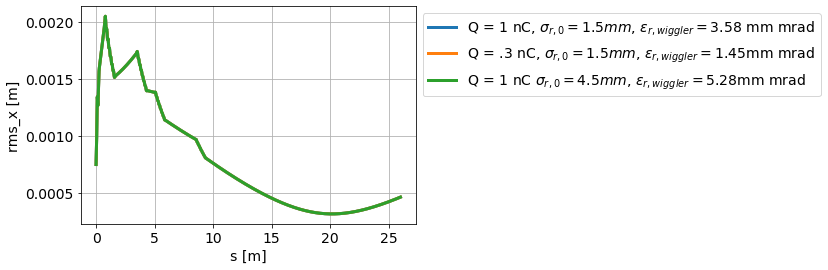

In [5]:
xax = 1
yax = 5
fig, ax = plt.subplots()
for pref in prefixes:
    [stat, names, units] = getStats(pref + generic_fn + '.stat', show = False)
    x = np.array( stat[names[xax]] )
    labxax = str( names[xax] + ' [' + units[xax] + ']')
    y = np.array( stat[names[yax]] )
    labyax = str( names[yax] + ' [' + units[yax] + ']')
    ax.plot( x, y, lw = 3 )
    # ax.set_ylim(bottom = 0, top  = 10)
    print('end y value = ', y[-1])
ax.set_xlabel(labxax, fontsize = fs)
ax.set_ylabel(labyax, fontsize = fs)
ax.tick_params( axis = 'both', labelsize = fs)
# ax.legend(prefixes, fontsize = fs)
leg = ['Q = 1 nC, $\sigma_{r,0} = 1.5 mm$, $\sigma_{r,wiggler} = 566 \mu m$',
       'Q = .3 nC, $\sigma_{r,0} = 1.5 mm$, $\sigma_{r,wiggler} = 461 \mu m$',
       'Q = 1 nC $\sigma_{r,0} = 4.5 mm$, $\sigma_{r,wiggler} = 602 \mu m$',]
leg = ['Q = 1 nC, $\sigma_{r,0} = 1.5 mm$, $\epsilon_{r,wiggler} = 3.58$ mm mrad',
       'Q = .3 nC, $\sigma_{r,0} = 1.5 mm$, $\epsilon_{r,wiggler} = 1.45$mm mrad',
       'Q = 1 nC $\sigma_{r,0} = 4.5 mm$, $\epsilon_{r,wiggler} = 5.28$mm mrad',]
ax.legend(leg, fontsize = fs, bbox_to_anchor = [1., 1.])
ax.grid()
plt.savefig('plots/all_emit.png', bbox_inches='tight')
plt.show()
    

In [ ]:
fn = str( prefixes[-1] + 'data/' + generic_fn + '_DIST.dat')
dist = pd.read_csv( filepath_or_buffer = fn, skiprows = 1, sep = '\s+',
                    names = [ 'x', 'px', 'y', 'py', 't', 'pz', 'nBins'])
qs = ['t', 'y']
fig, ax = plt.subplots()
ax.hist(dist[qs[0]], bins = 200)
# ax.hist2d(dist[qs[0]], dist[qs[1]], bins = 200, cmin = 1)
ax.set_xlabel(qs[0], fontsize = fs)
ax.set_ylabel(qs[1], fontsize = fs)
ax.tick_params( axis = 'both', labelsize = fs)
ax.grid()
ax.set_title('Initial bunch distribution\n $\lambda$ = 3 ps', fontsize = fs)

# plt.text( .75, -.25, footnote, transform=ax.transAxes )
# plt.title(, fontsize = fs)
plt.savefig('plots/initialDist100.png', bbox_inches='tight')
    
plt.show()


# Phase Space

In [ ]:
# Evolution of phase space and current
useSteps = [ 0, 3 ]

fn = prefixes[-1] + generic_fn + '.h5'
fig, axs = plt.subplots( 2, len(useSteps), sharex = True, gridspec_kw={'hspace': .01} )
axs = axs.reshape( -1, order = 'F' )
for i, step in enumerate(useSteps):
    [ x, y, spos, nSteps ] = get_ps_xy( fn, step, 'z', 'E', False)
 #    x *= 1e3
    ax = axs[2*i]
    ax.tick_params( axis = 'both', labelsize = fs)
    ax.text( .3, 1.02, 'Spos ' + '%.2f' % Decimal(spos) + ' m' , transform=ax.transAxes, fontsize = fs )
    ax.hist2d( x/3e8*1e12, y, bins = 150, cmin = 1)
    ax = axs[2*i+1]
    ax.set_xlim(left = -11, right = 11)
    ax.tick_params( axis = 'both', labelsize = fs)
    ax.hist( x/3e8*1e12, bins = 500)
    ax.set_xlabel('z [ps]', fontsize = fs)
    if step == 0:
        axs[2*step].set_ylabel('E [MeV]', fontsize = fs)
        ax.set_ylabel('Density [arb]', fontsize  =fs )
fig.set_size_inches(12, 8)
fig.suptitle( fn[:-len(generic_fn+'.h5')], fontsize = fs )
plt.savefig('plots/1nC_phase_space_modulation.eps', bbox_inches='tight')
    

spos =  [11.477]


3.1212121500866488 -2.8721881195815513


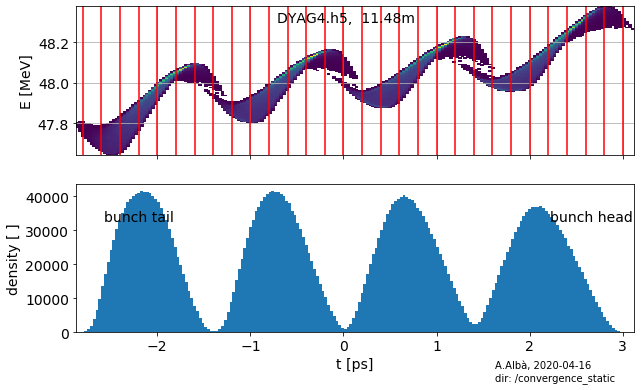

In [11]:
# Plot screens
screenFile = 'DYAG4.h5'
leg = ['Q = 1 nC, $\sigma_{r,0} = 1.5 mm$',
       'Q = .3 nC, $\sigma_{r,0} = 1.5 mm$',
       'Q = 1 nC $\sigma_{r,0} = 4.5 mm$',]

if len(prefixes) > 1:
    fig, ax = plt.subplots(2 * len(prefixes))
    for i,p in enumerate(prefixes):
        [x,y,spos] = get_screen_xy(p, screenFile, 'time', 'E', show = False)
        x *= -1e12
        x -= x.mean()
        ax[2*i].hist2d( x, y, bins = 300, cmin = 1 )
        ax[2*i].set_ylabel('E [MeV]', fontsize = fs)
        y = np.array(y)
        dE = np.std(y) / y.mean()
        sideText = prefixes[i] + '\n $\Delta E \% = $' + "{:.4f}".format(dE)
        # sideText = prefixes
        ax[2*i+1].hist( x, bins = 1000)
        ax[2*i+1].set_ylabel('density [arb]', fontsize = fs)
        ax[2*i].grid()
        # ax[2*i+1].set_xlabel('t [ps]', fontsize = fs)
        ax[2*i].tick_params(axis = 'y', labelsize = fs)
        ax[2*i+1].tick_params(axis = 'y', labelsize = fs)
        ax[2*i].text( 1.05, .75, leg[i],
                      fontsize = fs, transform = ax[2*i].transAxes  )
        ax[2*i+1].text( .85, .75, 'bunch head',
                      fontsize = fs, transform = ax[2*i+1].transAxes  )
        ax[2*i+1].text( .05, .75, 'bunch tail',
                      fontsize = fs, transform = ax[2*i+1].transAxes  )
    ax[-1].set_xlabel('t [ps]', fontsize = fs)
    ax[-1].tick_params(axis = 'x', labelsize = fs)
    fig.set_size_inches(10, 7 * len(prefixes))
    pmf.adjust_axes_limits( ax, 'x' )
    pmf.adjust_axes_limits( ax[::2], 'y' )
    pmf.adjust_axes_limits( ax[1::2], 'y' )
else:
    fig, ax = plt.subplots(2, sharex = True)
    [x,y,spos] = get_screen_xy(prefixes[0], screenFile, 'time', 'E', show = False)
    x *= -1e12
    x -= x.mean()
    ax[0].hist2d(x, y, bins = 200, cmin = 1)
    ax[0].set_ylabel('E [MeV]', fontsize = fs)
    ax[0].tick_params(axis = 'both', labelsize = fs)
    ax[0].grid()
    ax[1].hist(x, bins = 200)
    ax[1].set_xlabel('t [ps]', fontsize = fs)
    ax[1].set_ylabel('density [ ]', fontsize = fs)
    ax[1].tick_params(axis = 'both', labelsize = fs)
    ax[1].text( .85, .75, 'bunch head',
                    fontsize = fs, transform = ax[1].transAxes  )
    ax[1].text( .05, .75, 'bunch tail',
                    fontsize = fs, transform = ax[1].transAxes  )
    fig.set_size_inches(10, 6)
    nL = 30
    lines = np.linspace(-3, 3, nL + 1)
    for line in lines:
        ax[0].axvline(line, color = 'r')
# ax.set_xlabel(qx, fontsize = fs)
ax[-1].text( .75, -.32, footnote, transform=ax[-1].transAxes )
fig.suptitle(screenFile + ',  ' + "{:.2f}".format(spos) + 'm' , fontsize = fs, y = .87)
print(np.max(x), np.min(x))
plt.savefig('plots/yag4.png', bbox_inches='tight')
plt.show()


In [17]:
screenFile = 'DYAG4.h5'
[x,y,spos] = get_screen_xy(prefixes[0], screenFile, 'time', 'E', show = False)
fig, ax = plt.subplots(figsize = (10,4))
pmf.plotScreenXY(ax, x, y, ['t', 'E'], factors = [-1e12,1], limx = [], limy = [],
                 type = 'hist2d-hist', nbins = 300, fs = 14, ls = '-', lw = 2, color = 1, maxHH = .2)
ax.set_ylabel('E [MeV]', fontsize = 14)
plt.savefig('plots/yag4_pmf.png', bbox_inches='tight')
plt.show()



spos =  [11.477]


In [ ]:
numPr = len(prefixes)
charge = [ ]

fig, ax = plt.subplots( int(numPr/2), 2, sharex = True, sharey = False )
ax = ax.reshape(-1)

for i, pref in enumerate(prefixes[1:]):
    [x,y,spos] = get_screen_xy( pref, 'DYAG4.h5', 'time', 'E', show = False )
    x *= 1e12
    x -= np.min(x)
#     ax[i].hist2d( x, y, bins = 300, cmin = 1 )
    ax[i].hist( x, bins = 1000)
    ax[i].grid()
    ax[i].set_ylabel('density [arb]', fontsize = fs)
    ax[i].set_xlabel('t [ps]', fontsize = fs)
    ax[i].tick_params(axis = 'both', labelsize = fs)
    ax[i].text( .75, -.25, footnote, transform=ax[i].transAxes )
    ax[i].text( .05, .75, 'bunch charge = ' + str(charge[i]) + ' nC',
               fontsize = fs, transform = ax[i].transAxes  )
    
fig.set_size_inches(20, 8)
# ax.set_xlabel(qx, fontsize = fs)
fig.suptitle(str(generic_title + ',\n energy distribution after last cavity'), fontsize = fs)

plt.savefig('plots/Energy_end.eps', bbox_inches='tight')
plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tests/modulation_MT64_N1e5_1nC/
spos =  0.10999525890432466


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


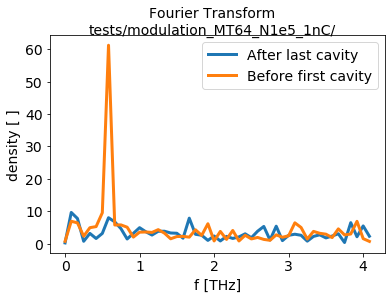

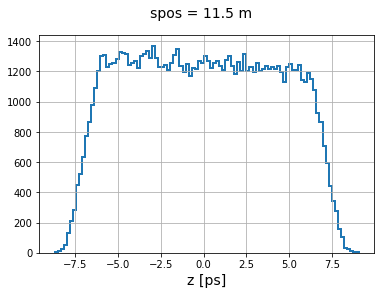

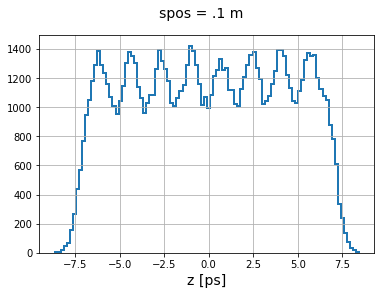

In [60]:
figFT, axFT = plt.subplots()

## After last cavity
pref = prefixes[-1]
nbins = 100
print(pref)
[x,y,spos] = get_screen_xy( pref, 'DYAG4.h5', 'time', 'x' )
x = ( x - x.mean() )*1e12
fig, ax = plt.subplots()
fig.suptitle('spos = 11.5 m', fontsize = fs)
ax.set_xlabel('z [ps]', fontsize = fs)
ax.hist(x, bins = nbins, histtype = 'step', linewidth = 2)
[x,y] = cutoff(x,y,[-6,6])
[y,x] = np.histogram(x, bins = nbins)
y -= int(np.average(y))
#ax.plot( x[:-1], y, lw = 3 )
ax.grid()
# Fourier transform        
dist = np.max(x) - np.min(x)
amp = np.fft.fft(y)[:nbins//2] / nbins
amp = np.abs(amp)
freq = np.arange( nbins//2 ) / dist
# Find peak frequencies
peaks, _ = find_peaks(amp, prominence = .2 )
amp_peaks = amp[peaks]
peaks = peaks / dist
# for p in peaks:
#     axFT.axvline(p, color = 'r')
axFT.plot(freq,amp, linewidth = 3)

# Right after the gun
fn = pref + generic_fn + '.h5'
[ x, y, spos, nSteps ] = get_ps_xy( fn, step = 0, qx = 'z', qy = 'y', boolprint = False)
print('spos = ', spos)
x = ( x - x.mean() )*1e12/3e8
fig, ax = plt.subplots()
fig.suptitle('spos = .1 m', fontsize = fs)
ax.set_xlabel('z [ps]', fontsize = fs)
ax.hist(x, bins = nbins, histtype = 'step', linewidth = 2)
[x,y] = cutoff(x,y,[-6,6])
[y,x] = np.histogram(x, bins = nbins)
y -= int(np.average(y))
#ax.plot( x[:-1], y, lw = 3 )
ax.grid()
# Fourier transform        
dist = np.max(x) - np.min(x)
amp = np.fft.fft(y)[:nbins//2] / nbins
amp = np.abs(amp)
freq = np.arange( nbins//2 ) / dist
# Find peak frequencies
peaks, _ = find_peaks(amp, prominence = .2 )
amp_peaks = amp[peaks]
peaks = peaks / dist
# for p in peaks:
#     axFT.axvline(p, color = 'r')
axFT.plot(freq,amp, linewidth = 3)
axFT.legend(['After last cavity','Before first cavity'], fontsize = fs)
axFT.set_xlabel('f [THz]', fontsize = fs)
axFT.set_ylabel('density [ ]', fontsize = fs )
axFT.tick_params(axis = 'both', labelsize = fs)
figFT.suptitle('Fourier Transform\n' + pref, fontsize = fs)
figFT.savefig('plots/den_FFT.eps', bbox_inches='tight')
plt.show()

tests/withUnd//bunch-sampling/bunch.txt
15 given names:  ['t', 'x', 'y', 'z_comoving', 'px', 'py', 'pz', 'sig_x', 'sig_y', 'sig_z', 'sig_px', 'sig_py', 'sig_pz', 'z_lab', 'bf'] 
 13  columns
Mesh limits z -0.021101582110048905 0.021101582110048905
Mesh limits x -0.0035 0.0035
Mesh limits y -0.0075 0.0075


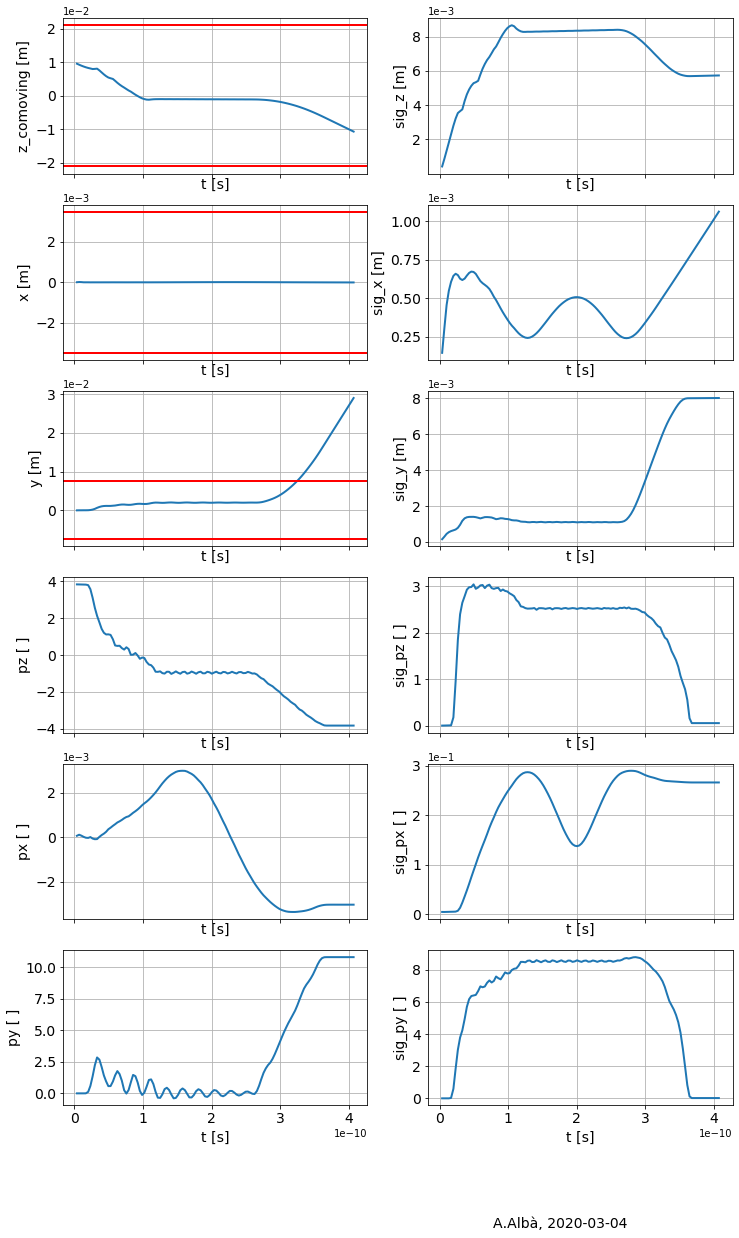

In [31]:
stats = []
stats.append( pmf.importStat( prefixes[0] + '/bunch-sampling/bunch.txt', show = True) )

names = [ 'z_comoving', 'sig_z', 'x', 'sig_x', 'y', 'sig_y',
             'pz', 'sig_pz', 'px', 'sig_px', 'py', 'sig_py']

fig, axs = plt.subplots( 6,2, figsize = ( 12, 20 ), sharex = True )
Ls = [7e-3, 15e-3, 3.5e-3]  # Mesh lengths
K = 10.81
E = 47.5  # MeV
Ls[2] *= E / .511 / np.sqrt(1 + .5 * K**2)  # * gamma_
dotted = [4,5]  # Indexes from fnames to plot with dotted lines
notPlot = []  # Indexes from fnames not to plot
legLocal = []
for i, ax in enumerate(axs.reshape(-1)):
    ax.grid()
    for j, stat in enumerate(stats):
        if j in notPlot:
            continue
        if j in dotted:
            ls = ':'
            lw = 3
        else:
            ls = '-'
            lw = 2
        pmf.plotStat(ax, stat, quants = ['t',names[i]], factors = [1, 1], color = j%(len(stats)), lw = lw, ls = ls )
        # legLocal.append(leg[j])
        # if int(i/10) == 0:
        #     ax.set_xlabel('')
        # axs[1,1].legend(legLocal, fontsize = fs, bbox_to_anchor = [1., 1.])
# Draw mesh limits
xyz = ['x', 'y', 'z']
for j in range(3):
    i  = (2 + j) % 3
    print('Mesh limits', xyz[i], -.5 * Ls[i], .5 * Ls[i])
    axs[j,0].axhline(-.5 * Ls[i], lw = 2, color = 'r')
    axs[j,0].axhline(.5 * Ls[i], lw = 2, color = 'r')
    # axs[j,0].set_ylim(bottom = -.5 * Ls[i], top = .5 * Ls[i])  # Mesh limits as plot limits
if not for_report:
    fig.text(.7, .04, footnote, fontsize = fs, ha='center')
# plt.savefig((pltpath + '/avg.png'),bbox_inches='tight')
plt.show()

In [6]:
fn = prefixes[2]
[data, screens] = pmf.importScreen( fn + 'bunch-screen/bunch-p#-screen#.txt', show = True )

columns =  ['q', 'x', 'y', 't', 'px', 'py', 'pz']
Number of screens =  4 , number of processors =  16
0 tests/case1_300pC_noSC/bunch-screen/bunch-p#-screen0.txt


1 tests/case1_300pC_noSC/bunch-screen/bunch-p#-screen1.txt


2 tests/case1_300pC_noSC/bunch-screen/bunch-p#-screen2.txt


3 tests/case1_300pC_noSC/bunch-screen/bunch-p#-screen3.txt


Screens at  [-0.12, 0.2, 0.6, 0.95]


Npart =  100000


Npart =  100000


Npart =  100000


Npart =  100000


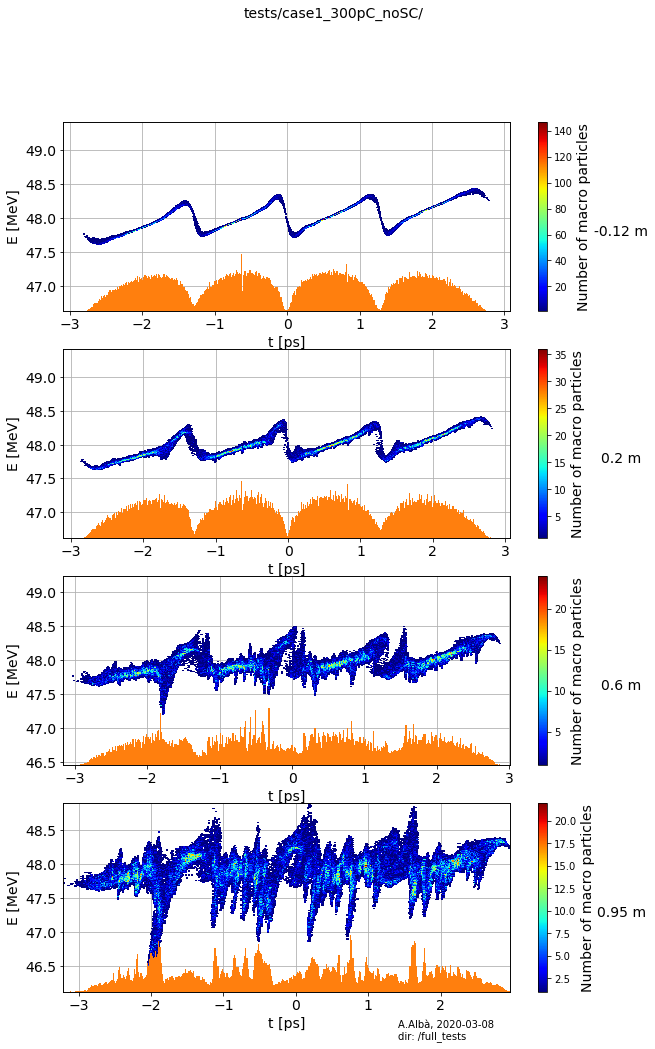

In [13]:
# Plot all screens for one folder
fig, ax = plt.subplots( len(screens), 1, figsize = ( 10, 4*len(screens) ), sharey = False, sharex = False )
if len(screens) > 1:
    ax = ax.reshape(-1)
    for i in range(len(screens)):
        [x,y] = pmf.plotScreen( ax[i], data, ['t', 'E'], screenNum = i, type = 'hist2d-hist', factors = [-1e12,1e-6], nbins = 400, color = 1)
        ax[i].text( 1.25, .4, str(screens[i]) + ' m', transform=ax[i].transAxes, fontsize = fs, ha='center' )
        ax[i].grid()
        print('Npart = ', len(x))
        # ax[i].set_xlim(left = 0.5, right = 0.8)
        # ax[i].set_ylim(bottom = -1e-1, top = 1e-1)

    pmf.adjust_axes_limits( ax, 'x' )
    pmf.adjust_axes_limits( ax, 'y' )
else:
    [x,y] = pmf.plotScreen( ax, data, ['x', 'px'], screenNum = 0, type = 'hist2d', factors = [-1e12,1e-6], nbins = 100, color = 1)
 
fig.suptitle(fn, fontsize = fs)
ax[-1].text( .75, -.25, footnote, transform=ax[-1].transAxes )
# plt.savefig( ('plots' + '/energy_case1_300pC_noSC.png'), bbox_inches='tight' )    
plt.show()
